In [2]:
import sys
import pandas as pd
import numpy as np
import os
sys.path.append('../')

# Building batches for training neural nets

Welcome! This is the third tutorial of the [series](https://github.com/analysiscenter/radio/blob/master/tutorials), covering lung cancer research using RadIO. In this tutorial you'll learn about `sample_nodules`-action, that allows to **sample interesting parts of scans** along with cancerous masks, thus considerably augmenting the dataset for a segmenting net. You will also take a look at `Pipelines`-submodule, which contains implementations of several ready-made workflows for preprocessing. If you haven't read the first two tutorials, we encourage you to do that before tackling this one. Anyways, here is a quick reminder.

## Not-so-quick reminder

When using RadIO, the first step is always to set up a `Dataset` - a structure (`instance` of a `Dataset`-class), indexing set of voluminous ct-scans on disk:

In [3]:
from radio.dataset import FilesIndex, Dataset
from radio import CTImagesMaskedBatch

LUNA_MASK = '/data/MRT/luna/s*/*.mhd'                                      # set glob-mask for scans from Luna-dataset here
luna_index = FilesIndex(path=LUNA_MASK, no_ext=True)                       # preparing indexing structure
luna_dataset = Dataset(index=luna_index, batch_class=CTImagesMaskedBatch)

Machine learning-solutions always start with preprocessing. RadIO thinks of preprocessing as of chained sequence of actions -  a `Pipeline`. Each `Pipeline` represents a *plan* of what is going to happen with data, rather than a real computation, and is made of actions, implemented in RadIO ([or by you](https://analysiscenter.github.io/lung_cancer/intro/preprocessing.html#writing-your-own-actions)). E.g., you can set up a simple preprocessing pipeline, including `load` from [Luna dataset](https://luna16.grand-challenge.org/)-format and `resize` to shape **[92, 256, 256]** in a following way:

In [4]:
from radio.dataset import Pipeline                 # the cell executes fast
simple_preproc = (Pipeline()                       # we only write a plan
                  .load(fmt='raw')                 # no computations here
                  .resize(shape=(92, 256, 256)))   # it happens later

It might be a good idea to replace `resize` with `unify_spacing`, that not only changes shape of scans, but also zooms them to the same scale:

In [5]:
other_simple_preproc = (Pipeline()
                        .load(fmt='raw')
                        .unify_spacing(shape=(92, 256, 256), spacing=(3.5, 1.0, 1.0)))

You can also add some data-augmenting actions to your pipeline. E.g., `rotate` of scans or cropping out its central part using `central_crop`.

In [6]:
augmenting_pipeline = (Pipeline()
                       .load(fmt='raw')
                       .unify_spacing(shape=(92, 256, 256), spacing=(3.5, 1.0, 1.0))
                       .rotate(angle=30)
                       .central_crop(crop_size=(64, 192, 192)))

You can also get your hands on target for a segmenting net - *cancerous masks*, by adding `fetch_nodules_info` and `create_mask` to a preprocessing pipeline:

In [7]:
nodules_df = pd.read_csv('/data/MRT/luna/CSVFILES/annotations.csv')
nodules_df.head(1)

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471


In [8]:
preprocessing = (Pipeline()
                 .load(fmt='raw')
                 .unify_spacing(shape=(92, 256, 256), spacing=(3.5, 1.0, 1.0))
                 .fetch_nodules_info(nodules_df)
                 .create_mask())

Remember, real computation happens **only** when you pass a part of your `Dataset` - a `Batch` through the workflow: 

In [9]:
batch = (luna_dataset >> preprocessing).next_batch(batch_size=3, shuffle=False)

In [10]:
from utils import get_nodules_pixel_coords
get_nodules_pixel_coords(batch).head(2)

,numeric_ix,coordZ,coordY,coordX,diameter_pixels
0,1,32,137,77,10
1,1,41,164,207,4


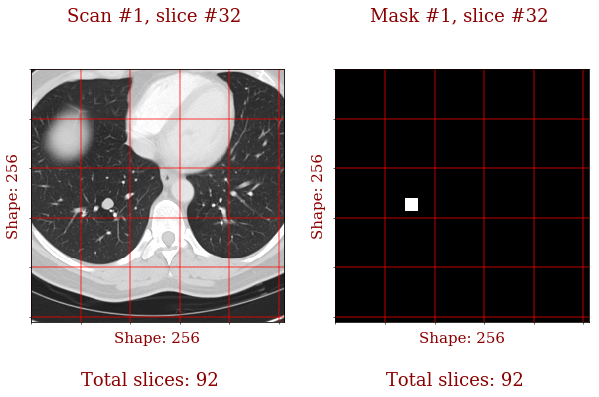

In [11]:
from utils import show_slices
show_slices(batch, 1, [32, 32], components=['images', 'masks'], clims=[(-1200, 300), (0, 1)])

At first glance, nothing stops you now from training a segmenting net on full-sized scans. This, however, would require either a **very fast** CPU or a GPU with **a lot** of memory, as few full-sized scans can fit in, say, 8 GB of 1080 Ti-memory. Consider also the following: frequently, scans of Luna-dataset contain more than one cancerous nodule. What a waste to use a scan like that as only one training example! That being said, it may be a good idea to crop out **parts of scans** and train a net on these parts. Action `sample_nodules` allows you to do just that, as you will see in a minute.

## Sampling batches of crops with `sample_nodules`

### Basic usage

Loaded cancerous masks are necessary requirement for running `sample_nodules`. So, your pipeline should start with something like that:  

In [12]:
preprocessing = (Pipeline()
                 .load(fmt='raw')
                 .unify_spacing(shape=(128, 256, 256), spacing=(3.5, 1.0, 1.0))
                 .fetch_nodules_info(nodules_df)
                 .create_mask())

Say, you want to generate batches of **8** crops of shape **(16, 32, 32)**. You need to simply add `sample_nodules` to your `preprocessing`, specifying `batch_size` and `nodule_size`:

In [13]:
crops_sampling_pipeline = preprocessing.sample_nodules(batch_size=8, nodule_size=(16, 32, 32))

Check out the results by passing a batch of 5 scans through the workflow:

In [14]:
np.random.seed(42)
batch_crops = (luna_dataset >> crops_sampling_pipeline).next_batch(5, shuffle=False)

In [15]:
get_nodules_pixel_coords(batch_crops).head(1)

,numeric_ix,coordZ,coordY,coordX,diameter_pixels
0,0,8,16,16,10


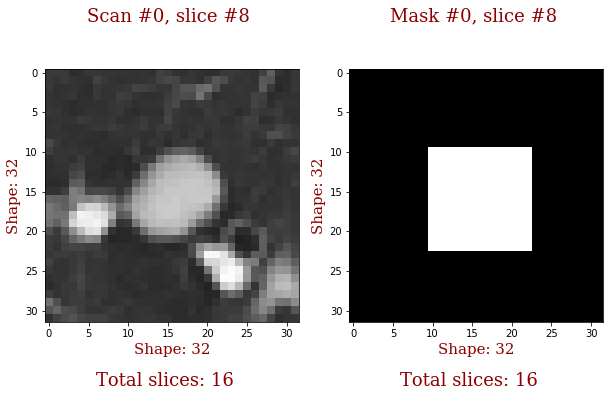

In [16]:
show_slices(batch_crops, 0, 8, components=['images', 'masks'], clims=[(-1200, 300), (0, 1)], grid=False)

### Balancing batches: changing `share` of cancerous crops

You can see that generated batch contains **8** crops: 

In [17]:
len(batch_crops)

8

Still, how much of them contain cancer? Let's find this out by printing number of cancerous pixels in each crop:

In [18]:
from utils import num_of_cancerous_pixels
num_of_cancerous_pixels(batch_crops)

,Scan 0,Scan 1,Scan 2,Scan 3,Scan 4,Scan 5,Scan 6,Scan 7
Number of cancerous pixels:,676,50,25,50,72,72,0,0


So, **six out of eight** crops contain cancerous pixels. The last two crops are simply cropped from random locations inside the scans. You may want to change the proportion and generate a balanced batch with **half (that is, four out of eight)** of crops being cancerous. For this you only need to set parameter `share` to **0.5**:

In [19]:
crops_sampling_pipeline = preprocessing.sample_nodules(batch_size=8, nodule_size=(16, 32, 32),
                                                       share=(0.5))

In [20]:
batch_crops = (luna_dataset >> crops_sampling_pipeline).next_batch(5, shuffle=False)

There are only **4** crops containing cancer in a generated batch:

In [21]:
num_of_cancerous_pixels(batch_crops)

,Scan 0,Scan 1,Scan 2,Scan 3,Scan 4,Scan 5,Scan 6,Scan 7
Number of cancerous pixels:,2646,50,72,676,0,0,0,0


Importantly, generating batches of crops with `sample_nodules` involves setting **two different `batch_size`-parameters**. The first one appears directly in `sample_nodules` action and defines the *size of a resulting batch of crops*. In its turn, the second one is a parameter of `next_batch` and defines the number of scans flowing into the workflow:

![title](imgs/flow_with_sn.png)

When setting parameters `share`, `batch_size` in `next_batch` and `batch_size` in `sample_nodules`, keep in mind that cancerous nodules occur with freqency **~1.3 nodules per scan** in Luna-dataset. That is, to generate batch of crops with **10** cancerous nodules, you should take not less than **8-10** (=10 / 1.3 + "just-in-case" margin) scans. E.g., with this combination of parameters

* `next_batch`: `batch_size` = 10
*  `sample_nodules`: `share` = 0.6
* `sample_nodules`: `batch_size` = 20

you will get the expected **12 (=20 * 0.6)** cancerous nodules and **8** noncancerous for most batches. In the same time, `batch_size=5` in `next_batch` is unlikely to yield **12** cancerous crops. In this case, `sample_nodules` just takes all cancerous crops it can find, and complements them with random crops to form a batch of expected size (**20**, in our example).  

### Building batches with only cancerous crops

You may sometimes want to generate batches containing only (and all) cancerous crops, that can be found in a batch, flowing into a pipeline. For that you only have to set `batch_size` to `None` and `share` to `1.0`:  

In [22]:
crops_sampling_pipeline = preprocessing.sample_nodules(batch_size=None, nodule_size=(16, 32, 32),
                                                       share=1.0)

In this case, however, you will end up getting batches of different sizes in different runs of `next_batch`:

In [23]:
np.random.seed(42)
batch_crops_1 = (luna_dataset >> crops_sampling_pipeline).next_batch(4)
batch_crops_2 = (luna_dataset >> crops_sampling_pipeline).next_batch(4)

In [24]:
len(batch_crops_1)

5

In [25]:
len(batch_crops_2)

9

Note that all crops contain cancer now:

In [26]:
num_of_cancerous_pixels(batch_crops_1)

,Scan 0,Scan 1,Scan 2,Scan 3,Scan 4
Number of cancerous pixels:,25,784,363,784,1620


### Randomizing locations of cancer in crops

Take a look one more time at a cancerous crop:

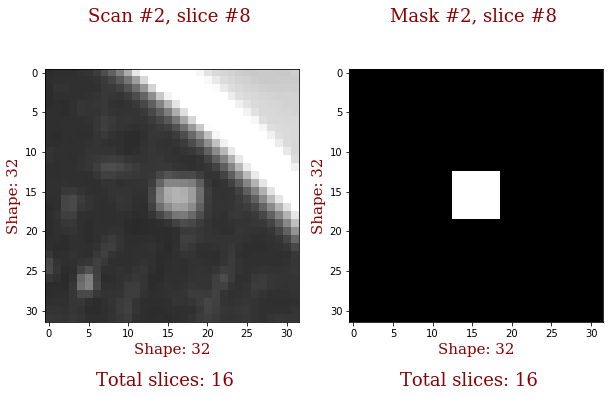

In [27]:
show_slices(batch_crops, 2, 8, components=['images', 'masks'], clims=[(-1200, 300), (0, 1)],
            grid=False)

You can see that cancer is located in the **center** of the crop. This is the default behaviour of `sample_nodules`. To avoid possible overfitting, `you` can introduce variability in the location of cancer inside crops by supplying `variance`-parameter:

In [28]:
crops_sampling_pipeline = preprocessing.sample_nodules(batch_size=None, nodule_size=(16, 32, 32),
                                                       share=1.0, variance=(9, 36, 36))

Note that `variance` should always be a sequence of three numbers. Each number is a variance of a zero-mean normal distribution used for sampling locations of cancer inside crops. Try it out:

In [29]:
np.random.seed(42)
batch_crops = (luna_dataset >> crops_sampling_pipeline).next_batch(5, shuffle=False)

In [30]:
get_nodules_pixel_coords(batch_crops).head(2)

,numeric_ix,coordZ,coordY,coordX,diameter_pixels
0,0,9,7,18,4
1,1,4,22,25,16


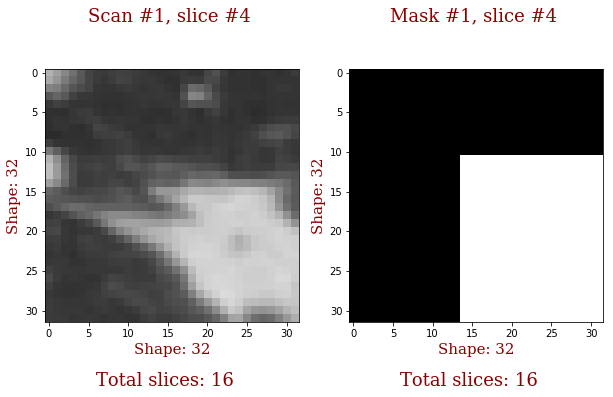

In [31]:
show_slices(batch_crops, 1, 4, components=['images', 'masks'], clims=[(-1200, 300), (0, 1)],
            grid=False)

The basic rule of thumb is to chose `variance` in a way, so that squared root of `variance` wouldn't exceed the quarter of size of crop (`nodule_size`) along respective axis (read about [$2\sigma$](https://en.wikipedia.org/wiki/68–95–99.7_rule)).

## Shortcut to RadIO capabilities: `pipelines`-submodule

Up to this point we've covered a lot of actions (`unify_spacing`, `resize`, `sample_nodules`, `rotate`,...) that offer flexible preprocessing capabilities. Still, chaining them in a correct way in a workflow can be a challenge. To make life easier for you, RadIO-team prepared a `pipelines`-submodule, incroporating several ready-to-use workflows. These are: `get_crops` - a simple workflow, preparing batches of crops for training a neural net, and workflows `split_dump` and `combine_crops`, that allow for **very fast** generation of training examples for neural networks.

### `get_crops`

You can make a fresh crops-generating workflow in one line of code. Do not forget to supply `nodules`-dataframe:

In [32]:
from radio.pipelines import get_crops
crops_sampling = get_crops(nodules_df)

Most importantly, `workflows` produced by `get_crops` contain actions `unify_spacing` and `sample_nodules`. RadIO team set the arguments of these actions to good [default values](link-on-default). However, nothing stops you from setting your own parameters. E.g., you may want to generate batches of **6** cancerous and **4** noncancerous crops of shape **[24, 48, 48]**:

In [33]:
crops_sampling = get_crops(nodules_df, share=0.6, batch_size=10, nodule_shape=(24, 48, 48))

Check out batches generated by this workflow.

In [34]:
batch_crops = (luna_dataset >> crops_sampling).next_batch(7)

Check that **six out of ten** crops are indeed cancerous:  

In [35]:
num_of_cancerous_pixels(batch_crops)

,Scan 0,Scan 1,Scan 2,Scan 3,Scan 4,Scan 5,Scan 6,Scan 7,Scan 8,Scan 9
Number of cancerous pixels:,405,864,0,144,5427,5193,0,0,0,0


In [36]:
get_nodules_pixel_coords(batch_crops).head(1)

,numeric_ix,coordZ,coordY,coordX,diameter_pixels
0,0,9,21,23,7


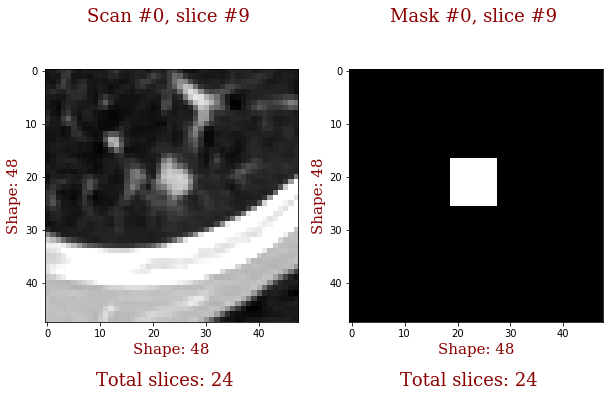

In [38]:
show_slices(batch_crops, 0, 9, components=['images', 'masks'], clims=[(0, 255), (0, 1)],
            grid=False)

**Note**: we recommend to use `get_crops` only for testing purposes, as it generates no more than a couple of thousand of training examples in one pass through Luna-dataset (which takes several hours to complete). For production and research we encourage you to take a look at `split_dump` and `combine_crops`-workflows.

### Generating large datasets of crops with `split_dump`  and `combine_crops`

With `split_dump` you can generate (and dump on disk) more than **100000** training examples in one run through the Luna-dataset. Workflow `combine_crops` can then be used for loading balanced batches of generated crops. You should always use one pipeline after another, starting with `split_dump`.

**Step 1: `split_dump`**

As opposed to `get_crops`-workflow, that uses batches of several scans for sampling batches of **10-30** crops, `split_dump` samples **thousands** crops from each batch, and dumps them on disk. As a result, one run through Luna-dataset is all it takes to generate **100000** training examples. Importantly, `split_dump` dumps cancerous and noncancerous crops in *separate folders*. Keep it in mind, when you use the method to produce a workflow. Also, do not forget to supply Luna-annotations dataframe: 

In [39]:
from radio.pipelines import split_dump
cancerous_folder, non_cancerous_folder = '/data/crops_folder/cancer', '/data/crops_folder/noncancer'
crops_dumping = split_dump(cancerous_folder, non_cancerous_folder, nodules_df)

You can now `run` the whole dataset through the created workflow:

In [46]:
# (luna_dataset >> crops_dumping).run()

# running the whole dataset Luna through the workflow takes several hours
# so, think thoroughly before uncommenting the first line and running the cell!
# (crops will also take about 100GB of your disk-space)

At least for purposes of demonstration, it might be a better idea to `run` a small part of Luna through the workflow. Gladly, a `Dataset`-instance supports easy splitting on train-test-validation parts, just like that:

In [40]:
luna_dataset.cv_split([0.8, 0.1, 0.1])

You now have a train part of `Luna_dataset`, that has **80 %** of items from the whole Luna:  

In [41]:
len(luna_dataset.train)

710

In [42]:
len(luna_dataset)

888

For purposes of demonstration, we suggest you to pass an even smaller part through the workflow:

In [43]:
luna_dataset.cv_split([0.03])
len(luna_dataset.train)

27

In [51]:
# may take a couple of minutes
(luna_dataset.train >> crops_dumping).run()

You should now be able to see a lot of directories in `cancerous_folder` and `noncancerous_folder`:

In [44]:
len(os.listdir(cancerous_folder))

2900

In [45]:
len(os.listdir(non_cancerous_folder))

4120

These are crops, dumped with `dump`-action. Read the [documentation](https://analysiscenter.github.io/lung_cancer/intro/preprocessing.html#load-and-dump) to understand the content of folders and what `dump` does.

**Step 2: `combine_crops`**

`combine-crops` allows you create batches, balancing cancerous and noncancerous crops in any way you want. The workflow always works with crops created by `split_dump`. So, the first step is to associate datasets with folders, created in previous section:

In [46]:
cancer_index = FilesIndex(path=os.path.join(cancerous_folder, '*'), dirs=True)
non_cancer_index = FilesIndex(path=os.path.join(non_cancerous_folder, '*'), dirs=True)
cancer_set = Dataset(cancer_index, batch_class=CTImagesMaskedBatch)
non_cancer_set = Dataset(non_cancer_index, batch_class=CTImagesMaskedBatch)

That's it, you can create a fresh workflow using `combine_crops`:

In [48]:
from radio.pipelines import combine_crops
crops_sampling = combine_crops(cancer_set, non_cancer_set, batch_sizes=(5, 5))

Pay attention to parameter `batch_sizes`. In the example above, it is set to **(5, 5)**. This means, that each batch generated by crops_sampling, will contain **5** cancerous and **5** noncancerous crops. See it yourself:

In [49]:
np.random.seed(42)
batch_crops = crops_sampling.next_batch()
# wow! This works really fast!

In [50]:
num_of_cancerous_pixels(batch_crops)

,Scan 0,Scan 1,Scan 2,Scan 3,Scan 4,Scan 5,Scan 6,Scan 7,Scan 8,Scan 9
Number of cancerous pixels:,0,0,0,0,0,196,601,405,486,75


You may want to generate batches containing **8** cancerous crops and **2** noncancerous:

In [51]:
np.random.seed(42)
crops_sampling = combine_crops(cancer_set, non_cancer_set, batch_sizes=(8, 2))
batch_crops = crops_sampling.next_batch()

In [52]:
num_of_cancerous_pixels(batch_crops)

,Scan 0,Scan 1,Scan 2,Scan 3,Scan 4,Scan 5,Scan 6,Scan 7,Scan 8,Scan 9
Number of cancerous pixels:,0,0,196,601,405,486,75,200,196,1568


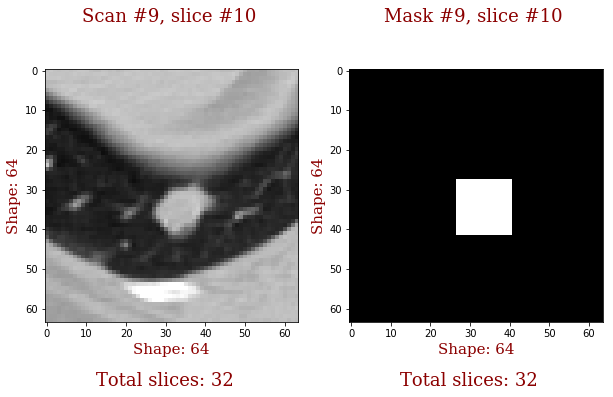

In [53]:
show_slices(batch_crops, 9, 10, components=['images', 'masks'], clims=[(0, 255), (0, 1)],
            grid=False)

### What's next?

After reading this tutorial you should be able to generate batches of crops with any type of balance using `sample_nodules`. You also should be able to use predefined workflow `split_dump` to **dump a large dataset of crops** on disk and then load balanced batches of cancerous/noncancerous crops in the blink of an eye with `combine_crops`.

In the [4th](https://github.com/analysiscenter/radio/blob/master/tutorials/RadIO.IV.ipynb) (and last) tutorial you will be able to make use of all these crops and train a **segmenting [VNet](https://arxiv.org/abs/1606.04797)-like model on task of cancer-segmentation**.